In [3]:
# Load Libraries

import os
import sys
import copy
import joblib
import pandas as pd
import numpy as np
import mlflow
import time
import warnings
from sklearn.preprocessing import Normalizer, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from IPython.display import Image

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import recall_score, f1_score, accuracy_score, precision_score
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix as con_mat
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


import causalnex
from causalnex.structure import StructureModel
from causalnex.structure.notears import from_pandas
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
from causalnex.discretiser import Discretiser
from causalnex.structure import DAGRegressor
from causalnex.inference import InferenceEngine
from causalnex.network import BayesianNetwork
from causalnex.network.sklearn import BayesianNetworkClassifier
from causalnex.discretiser.discretiser_strategy import (DecisionTreeSupervisedDiscretiserMethod,)
from causalnex.network import BayesianNetwork
from causalnex.inference import InferenceEngine

warnings.filterwarnings("ignore")

/home/nhgirma/anaconda3/envs/10acadenv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
merged_df = pd.read_csv('../data/merged.csv')

In [4]:
sys.path.append('../scripts')
from helpers import Helper
UTIL = Helper()

In [4]:
merged_df["date"]=merged_df["trip_start_time"].apply(lambda x: pd.to_datetime(x).date())
merged_df["hour"]=merged_df["trip_start_time"].apply(lambda x: pd.to_datetime(x).hour)

In [5]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1557740 entries, 0 to 1557739
Data columns (total 21 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   id                1557740 non-null  int64  
 1   order_id          1557740 non-null  int64  
 2   driver_id         1557740 non-null  int64  
 3   driver_action     1557740 non-null  object 
 4   lat               1557740 non-null  float64
 5   lng               1557740 non-null  float64
 6   trip_id           1557740 non-null  int64  
 7   trip_start_time   1557740 non-null  object 
 8   trip_end_time     1557740 non-null  object 
 9   trip_origin_lat   1557740 non-null  float64
 10  trip_origin_long  1557740 non-null  float64
 11  trip_destn_lat    1557740 non-null  float64
 12  trip_destn_long   1557740 non-null  float64
 13  trip_distance     1557740 non-null  float64
 14  trip_duration     1557740 non-null  float64
 15  speed(kmph)       1557740 non-null  float64
 16  

In [6]:

# merged_df['is_holiday'] = merged_df['trip_start_time'].apply(lambda x: UTIL.is_holiday(x))

In [7]:
# merged_df['is_holiday'].value_counts()

In [8]:
merged_df['is_weekend'] = merged_df['trip_start_time'].apply(lambda x: UTIL.isWeekend(x))

In [9]:
merged_df['is_weekend'].unique()

array([0, 1])

In [10]:
# merged_df[merged_df['trip_duration']<=10]
merged_df["fulfilled"] = (merged_df["driver_action"] == "accepted") & (merged_df["trip_duration"] >=10)

In [11]:
merged_df.head(3)

,id,order_id,driver_id,driver_action,lat,lng,trip_id,trip_start_time,trip_end_time,trip_origin_lat,...,trip_distance,trip_duration,speed(kmph),year,month,day_of_week,date,hour,is_weekend,fulfilled
0,1,392001,243828,accepted,6.602207,3.270465,392001,2021-07-01 09:30:59,2021-07-01 09:34:36,6.601042,...,20.984319,3.0,419.686381,2021,7,Thursday,2021-07-01,9,0,False
1,2,392001,243588,rejected,6.592097,3.287445,392001,2021-07-01 09:30:59,2021-07-01 09:34:36,6.601042,...,20.984319,3.0,419.686381,2021,7,Thursday,2021-07-01,9,0,False
2,3,392001,243830,rejected,6.596133,3.281784,392001,2021-07-01 09:30:59,2021-07-01 09:34:36,6.601042,...,20.984319,3.0,419.686381,2021,7,Thursday,2021-07-01,9,0,False


In [12]:
!pip install geopy
from geopy.distance import great_circle as GRC
# add proximity feature
merged_df['driver_proximity'] = merged_df.apply(lambda x: GRC( (x['lat'], x['lng']),(x['trip_origin_lat'], x['trip_origin_long'])).m, axis=1)


In [13]:
merged_df['driver_proximity']

0           693.616345
1          1554.088493
2           788.354435
3           694.071952
4          1623.331351
              ...     
1557735    3276.008974
1557736    3403.414221
1557737    2999.369716
1557738    3276.008974
1557739    3624.744473
Name: driver_proximity, Length: 1557740, dtype: float64

In [14]:
UTIL = Helper()

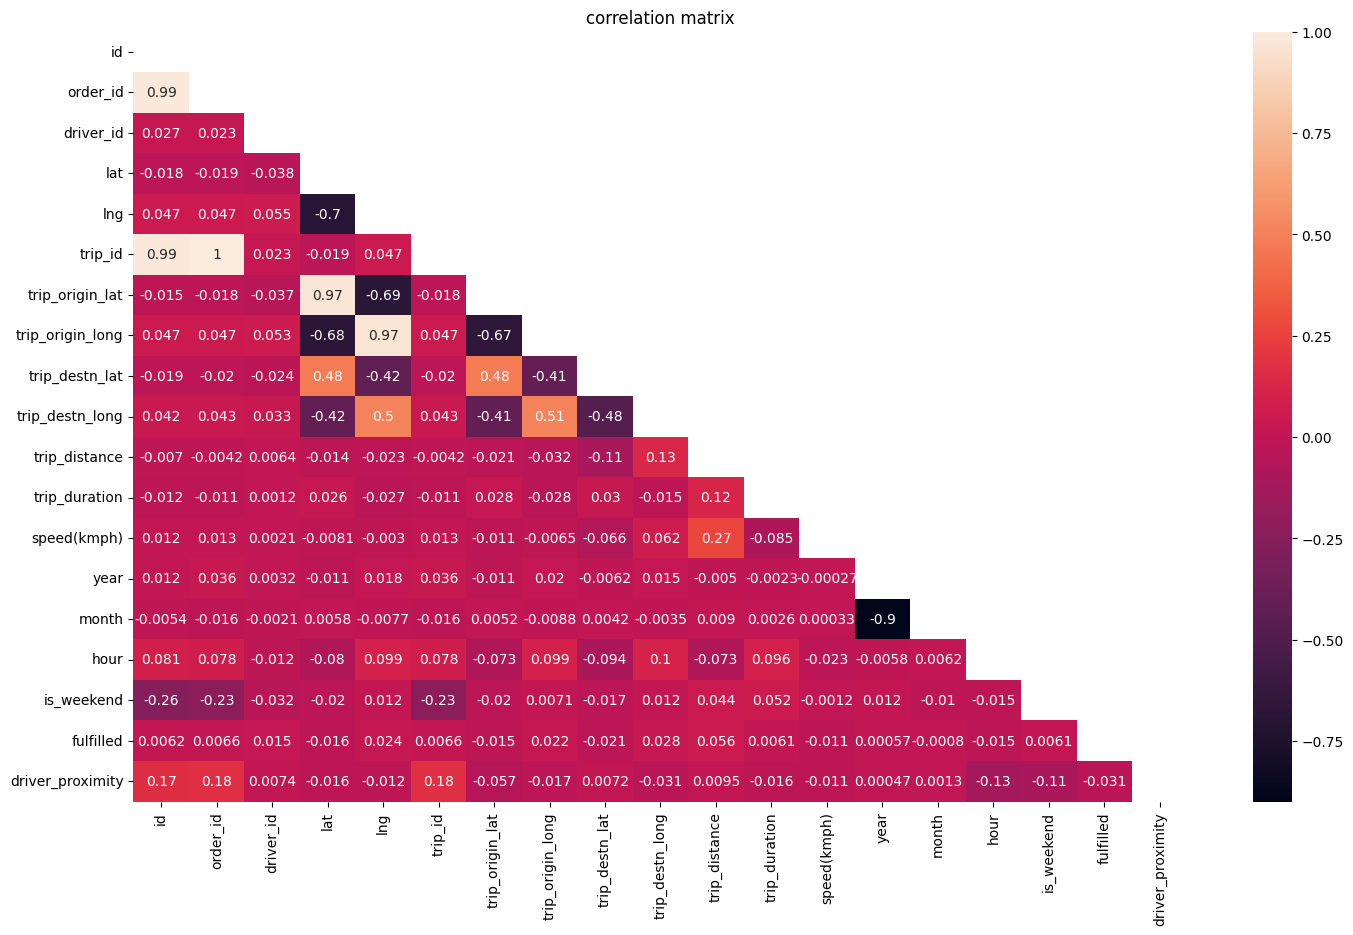

In [15]:
UTIL.show_corr(merged_df,'correlation matrix')

In [16]:
# plot_df = merged_df.copy()

In [17]:
# cols = ['driver_action','trip_start_time','trip_end_time','date']

In [18]:
# plot_df = plot_df.drop(cols,axis=1)

In [19]:
# def plot_heatmap( df: pd.DataFrame, title: str, cbar=False) -> None:
#     plt.figure(figsize=(12, 7))
#     sns.heatmap(df, annot=True, cmap='viridis', vmin=0,
#             vmax=1, fmt='.2f', linewidths=.7, cbar=cbar)
#     plt.title(title, size=18, fontweight='bold')
#     plt.show()
# #    

In [20]:
# plot_heatmap(plot_df,'corr')

In [3]:
# merged_df.to_csv('../data/cleaned_merged.csv',index=False)

In [5]:
clean_df = pd.read_csv('../data/cleaned_merged.csv')

In [6]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1557740 entries, 0 to 1557739
Data columns (total 24 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   id                1557740 non-null  int64  
 1   order_id          1557740 non-null  int64  
 2   driver_id         1557740 non-null  int64  
 3   driver_action     1557740 non-null  object 
 4   lat               1557740 non-null  float64
 5   lng               1557740 non-null  float64
 6   trip_id           1557740 non-null  int64  
 7   trip_start_time   1557740 non-null  object 
 8   trip_end_time     1557740 non-null  object 
 9   trip_origin_lat   1557740 non-null  float64
 10  trip_origin_long  1557740 non-null  float64
 11  trip_destn_lat    1557740 non-null  float64
 12  trip_destn_long   1557740 non-null  float64
 13  trip_distance     1557740 non-null  float64
 14  trip_duration     1557740 non-null  float64
 15  speed(kmph)       1557740 non-null  float64
 16  

In [7]:
# df_accepted = clean_df[clean_df.driver_action=='accepted'].copy(deep=True)

In [8]:
# df_accepted.head()

,id,order_id,driver_id,driver_action,lat,lng,trip_id,trip_start_time,trip_end_time,trip_origin_lat,...,trip_duration,speed(kmph),year,month,day_of_week,date,hour,is_weekend,fulfilled,driver_proximity
0,1,392001,243828,accepted,6.602207,3.270465,392001,2021-07-01 09:30:59,2021-07-01 09:34:36,6.601042,...,3.0,419.686381,2021,7,Thursday,2021-07-01,9,0,False,693.616345
10,11,392005,245597,accepted,6.549147,3.392184,392005,2021-07-01 10:53:36,2021-07-01 11:27:51,6.565088,...,34.0,14.342109,2021,7,Thursday,2021-07-01,10,0,True,1968.052120
61,62,392009,245600,accepted,6.644829,3.289328,392009,2021-07-01 06:39:51,2021-07-01 07:41:12,6.663648,...,61.0,4.958283,2021,7,Thursday,2021-07-01,6,0,True,2954.031519
128,129,392013,243892,accepted,6.435331,3.424317,392013,2021-07-01 08:44:09,2021-07-01 09:19:11,6.430817,...,35.0,9.617078,2021,7,Thursday,2021-07-01,8,0,True,1197.387881
141,142,392014,243781,accepted,6.498221,3.360042,392014,2021-07-01 06:43:07,2021-07-01 07:27:24,6.499156,...,44.0,26.021454,2021,7,Thursday,2021-07-01,6,0,True,197.983625


In [23]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1557740 entries, 0 to 1557739
Data columns (total 24 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   id                1557740 non-null  int64  
 1   order_id          1557740 non-null  int64  
 2   driver_id         1557740 non-null  int64  
 3   driver_action     1557740 non-null  object 
 4   lat               1557740 non-null  float64
 5   lng               1557740 non-null  float64
 6   trip_id           1557740 non-null  int64  
 7   trip_start_time   1557740 non-null  object 
 8   trip_end_time     1557740 non-null  object 
 9   trip_origin_lat   1557740 non-null  float64
 10  trip_origin_long  1557740 non-null  float64
 11  trip_destn_lat    1557740 non-null  float64
 12  trip_destn_long   1557740 non-null  float64
 13  trip_distance     1557740 non-null  float64
 14  trip_duration     1557740 non-null  float64
 15  speed(kmph)       1557740 non-null  float64
 16  

In [24]:
unwanted_cols = ['id','order_id','driver_id','lat','lng','trip_start_time','trip_end_time','trip_origin_lat',
                 'trip_origin_long','trip_destn_lat','trip_destn_long','year','month','hour','date','speed(kmph)']
clean_df = clean_df.drop(unwanted_cols,axis=1)

In [7]:
# clean_df = clean_df.drop('speed(kmph)',axis=1)

In [25]:
clean_df.head()

,driver_action,trip_id,trip_distance,trip_duration,day_of_week,is_weekend,fulfilled,driver_proximity
0,accepted,392001,20.984319,3.0,Thursday,0,False,693.616345
1,rejected,392001,20.984319,3.0,Thursday,0,False,1554.088493
2,rejected,392001,20.984319,3.0,Thursday,0,False,788.354435
3,rejected,392001,20.984319,3.0,Thursday,0,False,694.071952
4,rejected,392001,20.984319,3.0,Thursday,0,False,1623.331351


In [26]:
UTIL = Helper()

In [27]:
UTIL.label_encoder(clean_df,['driver_action','fulfilled','day_of_week'])

,driver_action,trip_id,trip_distance,trip_duration,day_of_week,is_weekend,fulfilled,driver_proximity
0,0,392001,20.984319,3.0,4,0,0,693.616345
1,1,392001,20.984319,3.0,4,0,0,1554.088493
2,1,392001,20.984319,3.0,4,0,0,788.354435
3,1,392001,20.984319,3.0,4,0,0,694.071952
4,1,392001,20.984319,3.0,4,0,0,1623.331351
...,...,...,...,...,...,...,...,...
1557735,1,517948,8.112927,102.0,0,0,0,3276.008974
1557736,1,517948,8.112927,102.0,0,0,0,3403.414221
1557737,1,517948,8.112927,102.0,0,0,0,2999.369716
1557738,1,517948,8.112927,102.0,0,0,0,3276.008974


In [28]:
normal_clean_df = UTIL.normalizer(clean_df,columns=['trip_distance','trip_duration','driver_proximity'])

In [29]:
normal_clean_df

,driver_action,trip_id,trip_distance,trip_duration,day_of_week,is_weekend,fulfilled,driver_proximity
0,0,392001,0.030239,0.004323,4,0,0,0.999533
1,1,392001,0.013501,0.001930,4,0,0,0.999907
2,1,392001,0.026608,0.003804,4,0,0,0.999639
3,1,392001,0.030220,0.004320,4,0,0,0.999534
4,1,392001,0.012926,0.001848,4,0,0,0.999915
...,...,...,...,...,...,...,...,...
1557735,1,517948,0.002475,0.031120,0,0,0,0.999513
1557736,1,517948,0.002383,0.029956,0,0,0,0.999548
1557737,1,517948,0.002703,0.033987,0,0,0,0.999419
1557738,1,517948,0.002475,0.031120,0,0,0,0.999513


In [30]:
normal_clean_df = normal_clean_df.drop('trip_id',axis=1)

In [31]:
normal_clean_df.fulfilled.value_counts()

0    1533970
1      23770
Name: fulfilled, dtype: int64

In [32]:
sm = StructureModel()
sm = from_pandas(normal_clean_df)

In [33]:
sm.edges

OutEdgeView([('driver_action', 'trip_distance'), ('driver_action', 'trip_duration'), ('driver_action', 'day_of_week'), ('driver_action', 'is_weekend'), ('driver_action', 'fulfilled'), ('driver_action', 'driver_proximity'), ('trip_distance', 'driver_action'), ('trip_distance', 'trip_duration'), ('trip_distance', 'day_of_week'), ('trip_distance', 'is_weekend'), ('trip_distance', 'fulfilled'), ('trip_distance', 'driver_proximity'), ('trip_duration', 'driver_action'), ('trip_duration', 'trip_distance'), ('trip_duration', 'day_of_week'), ('trip_duration', 'is_weekend'), ('trip_duration', 'fulfilled'), ('trip_duration', 'driver_proximity'), ('day_of_week', 'driver_action'), ('day_of_week', 'trip_distance'), ('day_of_week', 'trip_duration'), ('day_of_week', 'is_weekend'), ('day_of_week', 'fulfilled'), ('day_of_week', 'driver_proximity'), ('is_weekend', 'driver_action'), ('is_weekend', 'trip_distance'), ('is_weekend', 'trip_duration'), ('is_weekend', 'day_of_week'), ('is_weekend', 'fulfilled')

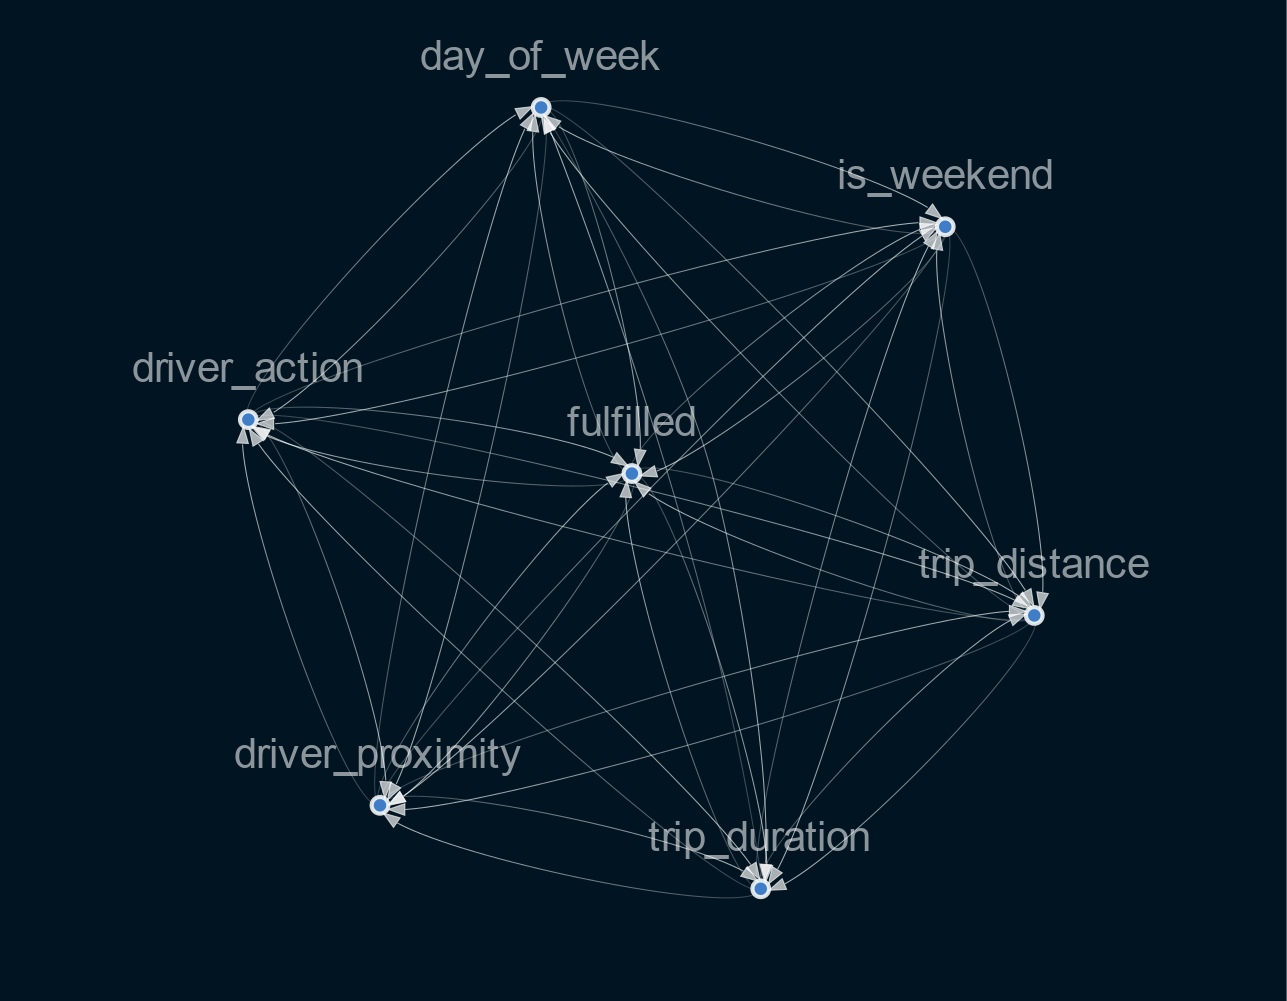

In [34]:
viz = plot_structure(
    sm,
    graph_attributes={"scale": "2"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
    
)
Image(viz.draw(format='png'))

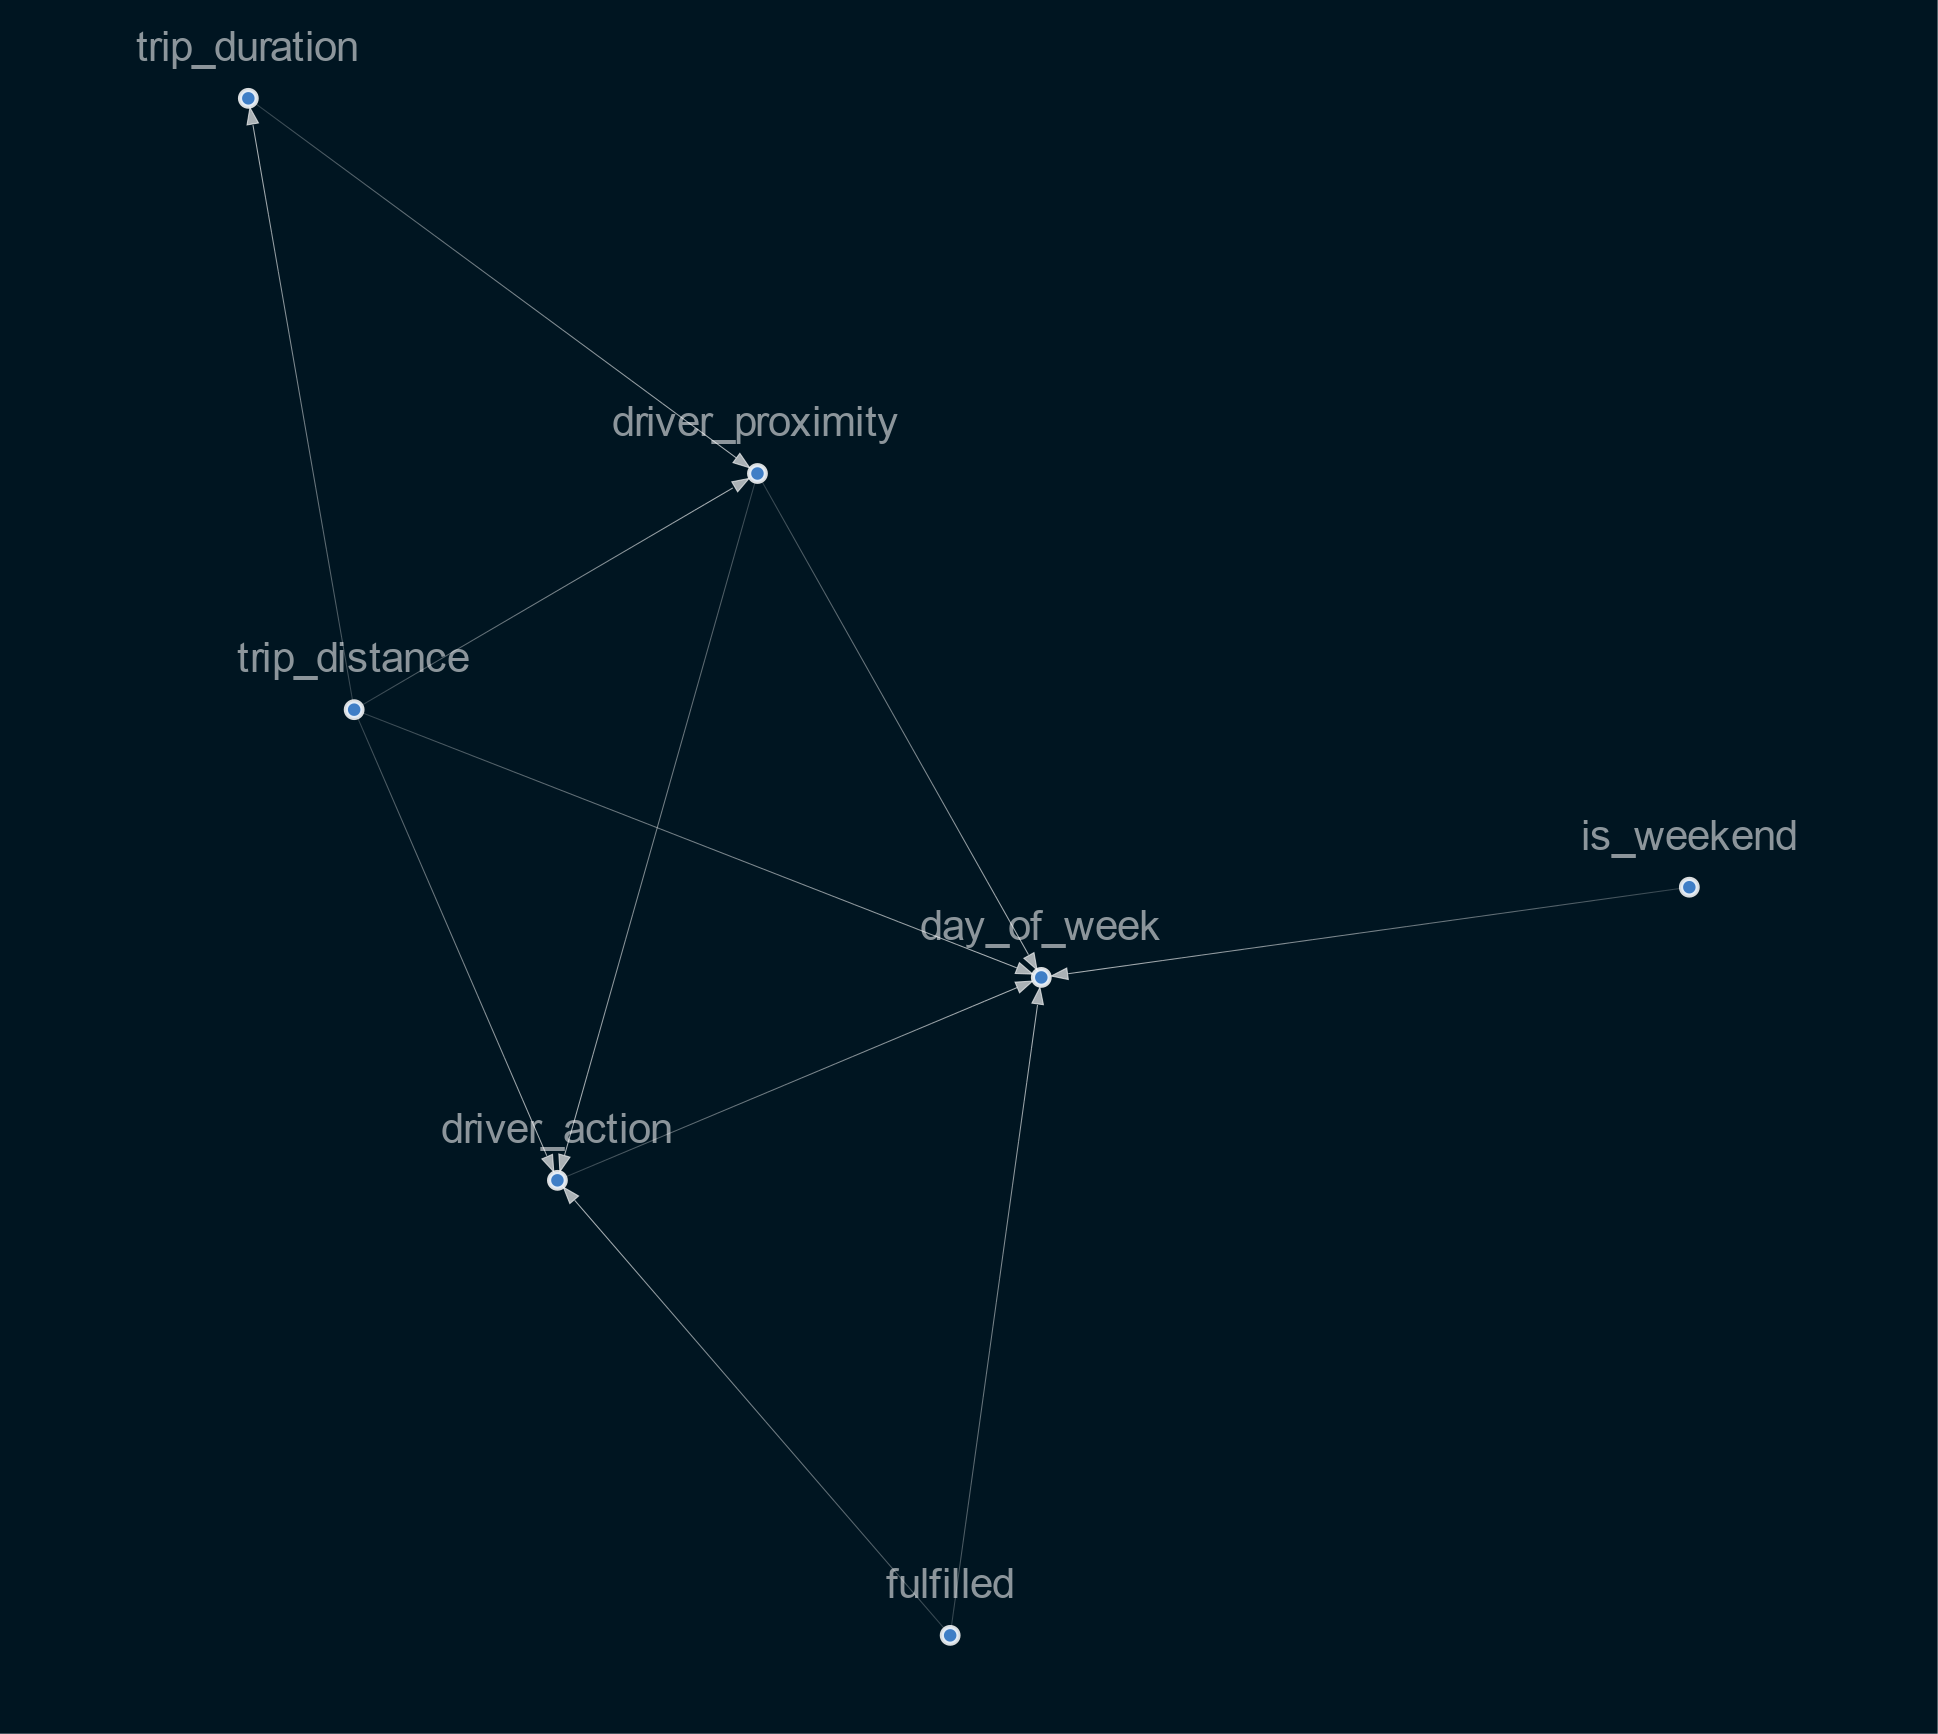

In [35]:
sm.remove_edges_below_threshold(0.8)
viz = plot_structure(
    sm,
    graph_attributes={"scale": "2"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

In [37]:
sm = from_pandas(normal_clean_df, tabu_edges=[("trip_duration","trip_distance"),("fulfilled","is_weekend")], w_threshold=0.8)


KeyboardInterrupt: 

In [36]:

# viz = plot_structure(
#     sm_en,
#     graph_attributes={"scale": "0.5"},
#     all_node_attributes=NODE_STYLE.WEAK,
#     all_edge_attributes=EDGE_STYLE.WEAK,
#     prog='fdp'
# )
# # Image(viz.draw(format='png'))